<h1>SVHN Classification using CNNs</h1>

---



# Importing Keras Modules


In [0]:
#Importing important modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Installing Tensorboard for Colab
!pip install tensorboardcolab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the Dataset

<h3>Import train and test sets of  SVHN dataset</h3>

In [0]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/Artificial Intelligence/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()


<h4>Visualizing the dataset</h4>
(Visualize first 25 test images from the dataset using matplotlib)  **2.5 Points**

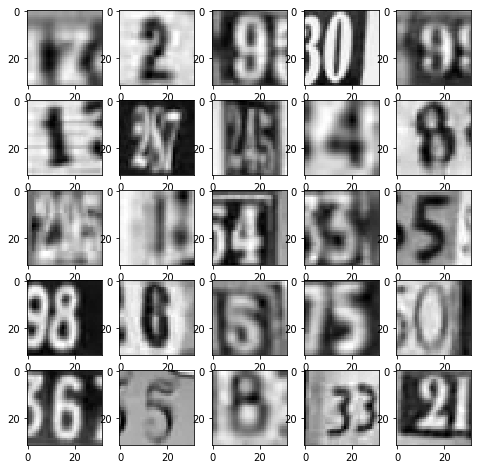

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
h = 10
w = 10
rows = 5
cols = 5
fig = plt.figure(figsize=(8,8))
for i in range(1,rows*cols+1):
  img = x_test[i]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img,cmap='gray')
plt.show()

<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [0]:
# input image dimensions
img_rows, img_cols = 32, 32

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (42000, 32, 32, 1))
(42000, 'train samples')
(18000, 'test samples')


In [0]:
batch_size = 25
num_classes = 10
epochs = 25

<h4>Convert Labels from digits to one hot vectors</h4>  **2.5 Points**

In [0]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test,num_classes)
y_train = to_categorical(y_train,num_classes)

# Building the CNN 

<h4>Define the layers of model</h4>  **5 Points**

In [0]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

<h4>Set Adam Optimizer and Loss function for training</h4>  **2.5 Points**

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
model.compile(optimizer=Adam(lr=0.001),loss=categorical_crossentropy,metrics=['accuracy'])

# Training the CNN - 10 Points

<h4>Initializing the Tensorboard callback for visualization of training</h4>

In [0]:
# Importing necessary libraries for tensorboard
from tensorflow.keras.callbacks import TensorBoard
from time import time
# Setting the directory to store the loss
tensorboard = TensorBoard(log_dir=".logs/{}".format(time()))

<h4>Initializing Early stopping and Model chekpoint callbacks </h4>

In [0]:
# if the validation loss is not going to change even 0.002 for more than 5 continuos epochs then
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.002,patience=5)
# Adding Model Checkpoint Callback function to the fit function which is going to save the weights whenever val_loss achieves a new loss value
# Hence saving the best weights occured during training
model_checkpoint = ModelCheckpoint('svhn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',monitor='val_loss',
                                   save_best_only=True,save_weights_only=True,mode='auto',period=1)



W0517 16:20:02.321784 139666827048832 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


<h4>Fit the model to the dataset</h4>

In [0]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard,early_stopping,model_checkpoint])

Train on 42000 samples, validate on 18000 samples
Epoch 1/25
   25/42000 [..............................] - ETA: 3:33:56 - loss: 2.3291 - accuracy: 0.0400

W0517 16:20:12.569196 139666827048832 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (0.234376). Check your callbacks.


42000/42000 [==============================] - 18s 422us/sample - loss: 1.1840 - accuracy: 0.6102 - val_loss: 0.6240 - val_accuracy: 0.8144
Epoch 2/25
42000/42000 [==============================] - 10s 244us/sample - loss: 0.6859 - accuracy: 0.7897 - val_loss: 0.4883 - val_accuracy: 0.8587
Epoch 3/25
42000/42000 [==============================] - 11s 261us/sample - loss: 0.5951 - accuracy: 0.8141 - val_loss: 0.4729 - val_accuracy: 0.8650
Epoch 4/25
42000/42000 [==============================] - 10s 236us/sample - loss: 0.5483 - accuracy: 0.8297 - val_loss: 0.4142 - val_accuracy: 0.8806
Epoch 5/25
42000/42000 [==============================] - 10s 238us/sample - loss: 0.5089 - accuracy: 0.8427 - val_loss: 0.4005 - val_accuracy: 0.8824
Epoch 6/25
42000/42000 [==============================] - 10s 243us/sample - loss: 0.4772 - accuracy: 0.8502 - val_loss: 0.3766 - val_accuracy: 0.8905
Epoch 7/25
42000/42000 [==============================] - 10s 231us/sample - loss: 0.4484 - accuracy: 0.8

# Evaluating the CNN

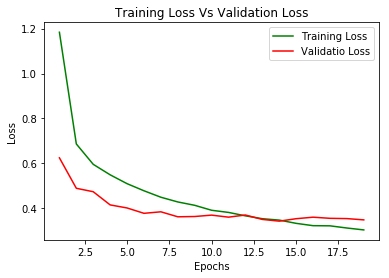

In [0]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1,20)
plt.plot(epochs,training_loss,'g',label="Training Loss")
plt.plot(epochs,validation_loss,'r',label="Validatio Loss")
plt.title("Training Loss Vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



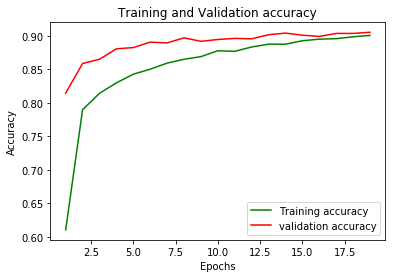

In [0]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,20)
plt.plot(epochs,training_accuracy,'g', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h4>Evaluate trained model on the test set</h4>  ** 2.5 Points**

In [0]:
model.evaluate(x_test,y_test,verbose=2)

18000/18000 - 2s - loss: 0.3474 - accuracy: 0.9053


[0.3474286636494928, 0.90533334]

<h4>Visualize 5 test set image predictions</h4>  **2.5 Points**

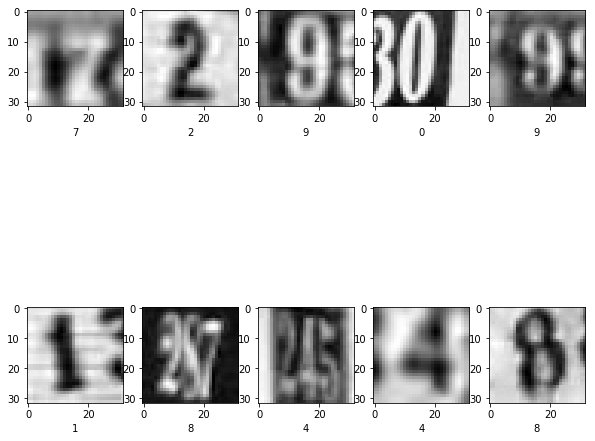

In [0]:
import numpy as np
fig = plt.figure(figsize=(10,10))
row = 2
col = 5
for i in range(1,row*col+1):
  fig.add_subplot(row,col,i)
  plt.imshow(x_test[i].reshape(32,32),cmap='gray')
  label = np.argmax(model.predict(x_test[i].reshape(1,32,32,1)))
  plt.xlabel(label)
  
plt.show()


# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4>  **2.5 Points**

In [0]:
# Save the pretrained models in a drive
model.save_weights("/content/drive/My Drive/Artificial Intelligence/svhn_checkpoint_14_loss0.3417.h5")